In [218]:
import matplotlib.pyplot as plt
import numpy as np
from rich import print as rprint
import pickle

In [219]:
# load data for imagenet
with open("../jobs/profiles/imagenet.pkl", "rb") as f:
    data = pickle.load(f)
rprint(f"Num profiles: {len(data['logs'])}")

Num profiles: 9633

In [220]:
# standardize plot
def standardize(plot, size=(10, 5)):
  plt.gcf().set_size_inches(*size)
  plt.grid(True)
  # set dpi
  plt.gcf().set_dpi(100)
  # set font
  plt.rcParams.update({'font.size': 12})

In [221]:
# extrapolate data
def extrapolate(x, y, extra_x, degree=3):
  # fit a curve with degree
  params = np.polyfit(x, y, degree)
  # evaluate polynomial at extra_x
  return np.polyval(params, extra_x)

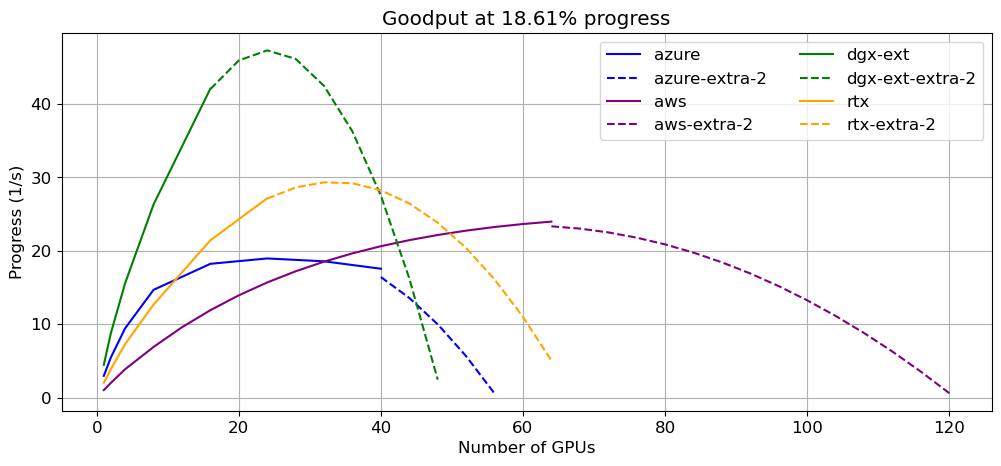

In [222]:
# plot data for an arbitrary index for all GPU types
configs = data["configs"]
logs = data["logs"]
config_ngpus = {gpu_type : configs[gpu_type]['num_gpus'] for gpu_type in configs.keys()}
idx = 2000
extra_ngpus = [1, 2]
extra_ngpus.extend([4*i for i in range(1, 96)])
extra_ngpus = np.array(extra_ngpus)
extrapolate_poly_degree = 2
gpu_type_to_colors_map = {
    "azure": "blue",
    "quad": "red",
    "dgx-ext": "green",
    "rtx" : "orange",
    "aws" : "purple"
}

for gpu_type in configs.keys():
    if gpu_type == 'quad':
        continue
    color = gpu_type_to_colors_map[gpu_type]
    num_gpus = config_ngpus[gpu_type]
    goodput = logs[idx]['goodputs'][gpu_type]
    goodput = np.array(goodput)
    plt.plot(num_gpus, goodput, label=f"{gpu_type}", color=color)
    # extrapolate this curve
    extra_goodput = extrapolate(x=num_gpus, y=goodput, extra_x=extra_ngpus, degree=extrapolate_poly_degree)
    valid_plot_idxs = (extra_ngpus >= num_gpus[-1]) & (extra_goodput >= 0)
    plot_x, plot_y = extra_ngpus[valid_plot_idxs], extra_goodput[valid_plot_idxs]
    plt.plot(plot_x, plot_y, linestyle='--', label=f"{gpu_type}-extra-{extrapolate_poly_degree}", color=color)
plt.legend(loc='upper right', ncols=2)
progress_perc = logs[idx]['progress'] / logs[-1]['progress'] * 100
plt.title(f"Goodput at {progress_perc:.2f}% progress")
plt.xlabel("Number of GPUs")
plt.ylabel("Progress (1/s)")
standardize(plt, size=(12, 5))

### Generate synthetic profiles ###

In [223]:
# basic one-phase job with sub-linear scaling
class SyntheticJob:
  def __init__(self, base_work_per_gpu, work_rate_per_gpu, work_attentuation_factor, \
               compute_time_system_overheads_factor, base_comm_per_gpu, work_comm_overlap_factor):
    self.base_work_per_gpu = base_work_per_gpu
    self.work_rate_per_gpu = work_rate_per_gpu
    self.work_attentuation_factor = work_attentuation_factor
    self.compute_time_system_overheads_factor = compute_time_system_overheads_factor
    self.base_comm_per_gpu = base_comm_per_gpu
    self.work_comm_overlap_factor = work_comm_overlap_factor
  
  def work(self, n):
    # ideal work scales linearly
    ideal_work = self.base_work_per_gpu * n
    # sub-linear scaling: useful work with n processors < n * useful work with 1 processor
    attenuation = (1 - self.work_attentuation_factor)**n
    # attenuation = 1
    return ideal_work * attenuation

  def compute_time(self, n):
    # ideal compute time scales linearly
    ideal_compute_time = self.work(n) / (n * self.work_rate_per_gpu)
    # filesystem, other contentions etc. increase compute time a bit
    system_overheads = (1 - self.compute_time_system_overheads_factor)**n
    # system_overheads = 1
    return ideal_compute_time / system_overheads
  
  def comm_time(self, n):
    # ideal comm time scales logarithmically for tree-based all-reduce
    ideal_comm_time = self.base_comm_per_gpu
    scaling = np.log2(n)
    return ideal_comm_time * scaling
  
  def iter_time(self, n):
    # model overlap between compute and communication for DLT jobs
    compute_time = self.compute_time(n)
    comm_time = self.comm_time(n)
    return compute_time + comm_time * (1 - self.work_comm_overlap_factor)

  def goodput(self, n):
    # rate of useful work done per second = work done / iteration time
    work = self.work(n)
    iter_time = self.iter_time(n)
    return work / iter_time

In [224]:
def plot_curves(configs, config_colors, max_ngpus=1024):
  max_i = max_ngpus // 4
  ngpus = [1, 2]
  ngpus.extend([4*i for i in range(1, max_i)])
  ngpus = np.array(ngpus)
  goodputs = {}
  for key, config in configs.items():
    jobobj = SyntheticJob(**config)
    goodputs[key] = np.asarray([jobobj.goodput(n) for n in ngpus])
  norm_factor = min([x[0] for x in goodputs.values()])
  for key, config in configs.items():
    goodput = goodputs[key] / norm_factor
    color = config_colors[key]
    plt.plot(ngpus, goodput, label=key, color=color)
    scaling = goodput[2:] / goodput[0]
    max_scaling, idx = np.max(scaling), np.argmax(scaling)
    max_scaling_gpus = ngpus[2:][idx]
    rprint(f"GPU type: {key}, max scaling: {max_scaling:.1f}x @ {max_scaling_gpus} GPUs")
  plt.legend(loc='upper right', ncols=3)
  plt.title("Synthetic job")
  # plt.yscale("log")
  # plt.xscale("log")
  plt.xlabel("Number of GPUs")
  plt.ylabel("Relative goodput")
  standardize(plt, size=(12, 3))
  goodputs["num_gpus"] = ngpus
  return goodputs

### Linearly scaling job profiles
* Short job: ~10000 GPU-secs, ~20GB model size
* Long job: ~500,000 GPU-secs, ~40GB model size

GPU type: DGX-A100-40GB, max scaling: 238.6x @ 252 GPUs

GPU type: A100-40GB-PCIe, max scaling: 191.9x @ 252 GPUs

GPU type: A10-24GB-PCIe, max scaling: 188.2x @ 252 GPUs

GPU type: RTX-2080Ti-11GB, max scaling: 156.6x @ 252 GPUs

GPU type: T4-16GB, max scaling: 181.6x @ 252 GPUs

GPU type: DGX-V100-32GB, max scaling: 233.2x @ 252 GPUs

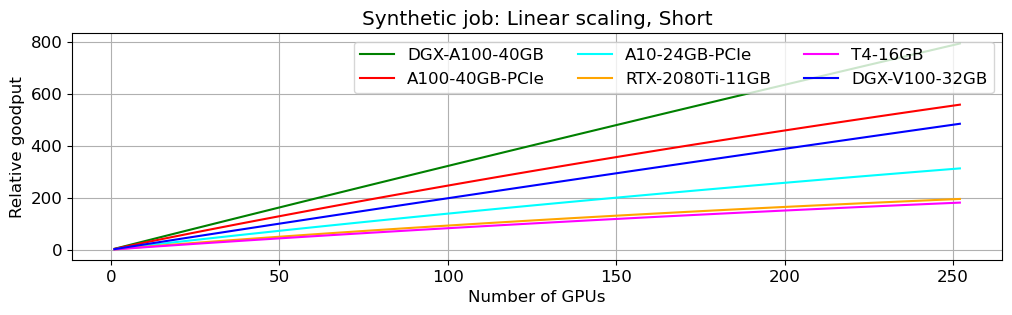

In [225]:
# Linear: short job
job_configs = {
  "DGX-A100-40GB": {'base_work_per_gpu': 400, 'work_rate_per_gpu': 40, 'work_attentuation_factor': 1e-3, 
                'compute_time_system_overheads_factor': 1e-4, 'base_comm_per_gpu': 1, 
                'work_comm_overlap_factor': 0.97},
  "A100-40GB-PCIe": {'base_work_per_gpu': 400, 'work_rate_per_gpu': 35, 'work_attentuation_factor': 1e-3, 
                     'compute_time_system_overheads_factor': 5e-4, 'base_comm_per_gpu': 2.5, 
                     'work_comm_overlap_factor': 0.92},
  "A10-24GB-PCIe": {'base_work_per_gpu': 200, 'work_rate_per_gpu': 20, 'work_attentuation_factor': 1e-3, 
                    'compute_time_system_overheads_factor': 5e-4, 'base_comm_per_gpu': 2.5, 
                    'work_comm_overlap_factor': 0.92},
  "RTX-2080Ti-11GB": {'base_work_per_gpu': 100, 'work_rate_per_gpu': 15, 'work_attentuation_factor': 2e-3, 
                      'compute_time_system_overheads_factor': 5e-4, 'base_comm_per_gpu': 3, 
                      'work_comm_overlap_factor': 0.92},
  "T4-16GB": {'base_work_per_gpu': 150, 'work_rate_per_gpu': 12, 'work_attentuation_factor': 2e-3, 
                      'compute_time_system_overheads_factor': 5e-4, 'base_comm_per_gpu': 3, 
                      'work_comm_overlap_factor': 0.92},
  "DGX-V100-32GB": {'base_work_per_gpu': 250, 'work_rate_per_gpu': 25, 'work_attentuation_factor': 1e-3, 
                    'compute_time_system_overheads_factor': 1e-4, 'base_comm_per_gpu': 1.8, 
                    'work_comm_overlap_factor': 0.97}
}
gpu_types_to_colors = {
  "DGX-A100-40GB": "green",
  "A100-40GB-PCIe": "red",
  "A10-24GB-PCIe": "cyan",
  "RTX-2080Ti-11GB": "orange",
  "T4-16GB": "magenta",
  "DGX-V100-32GB": "blue"
}
goodputs = plot_curves(job_configs, gpu_types_to_colors, max_ngpus=256)
plt.title("Synthetic job: Linear scaling, Short")
job_profile = {"max_progress": 350000, "goodputs": goodputs, "params": job_configs}
with open("../jobs/profiles/synthetic_linear_short.pkl", "wb") as f:
  pickle.dump(job_profile, f)

GPU type: DGX-A100-40GB, max scaling: 881.4x @ 1020 GPUs

GPU type: A100-40GB-PCIe, max scaling: 548.8x @ 1020 GPUs

GPU type: A10-24GB-PCIe, max scaling: 459.7x @ 1020 GPUs

GPU type: RTX-2080Ti-11GB, max scaling: 273.8x @ 764 GPUs

GPU type: T4-16GB, max scaling: 357.3x @ 892 GPUs

GPU type: DGX-V100-32GB, max scaling: 800.9x @ 1020 GPUs

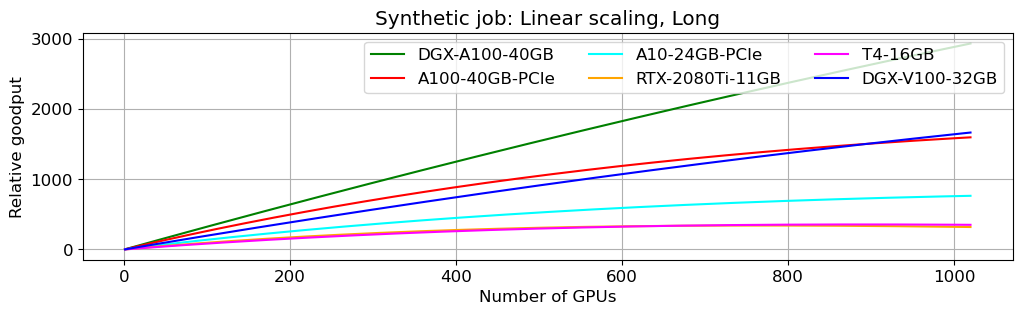

In [226]:
# Linear: long job
job_configs = {
  "DGX-A100-40GB": {'base_work_per_gpu': 1000, 'work_rate_per_gpu': 40, 'work_attentuation_factor': 1e-3, 
                'compute_time_system_overheads_factor': 1e-4, 'base_comm_per_gpu': 1.5, 
                'work_comm_overlap_factor': 0.97},
  "A100-40GB-PCIe": {'base_work_per_gpu': 1000, 'work_rate_per_gpu': 35, 'work_attentuation_factor': 1e-3, 
                     'compute_time_system_overheads_factor': 5e-4, 'base_comm_per_gpu': 2.5, 
                     'work_comm_overlap_factor': 0.92},
  "A10-24GB-PCIe": {'base_work_per_gpu': 400, 'work_rate_per_gpu': 20, 'work_attentuation_factor': 1e-3, 
                    'compute_time_system_overheads_factor': 5e-4, 'base_comm_per_gpu': 5.0, 
                    'work_comm_overlap_factor': 0.92},
  "RTX-2080Ti-11GB": {'base_work_per_gpu': 200, 'work_rate_per_gpu': 15, 'work_attentuation_factor': 2e-3, 
                      'compute_time_system_overheads_factor': 5e-4, 'base_comm_per_gpu': 5, 
                      'work_comm_overlap_factor': 0.92},
  "T4-16GB": {'base_work_per_gpu': 300, 'work_rate_per_gpu': 12, 'work_attentuation_factor': 2e-3, 
                      'compute_time_system_overheads_factor': 5e-4, 'base_comm_per_gpu': 5, 
                      'work_comm_overlap_factor': 0.92},
  "DGX-V100-32GB": {'base_work_per_gpu': 500, 'work_rate_per_gpu': 25, 'work_attentuation_factor': 1e-3, 
                    'compute_time_system_overheads_factor': 1e-4, 'base_comm_per_gpu': 4, 
                    'work_comm_overlap_factor': 0.97}
}
goodputs = plot_curves(job_configs, gpu_types_to_colors, max_ngpus=1024)
plt.title("Synthetic job: Linear scaling, Long")
job_profile = {"max_progress": 17500000, "goodputs": goodputs, "params": job_configs}
with open("../jobs/profiles/synthetic_linear_long.pkl", "wb") as f:
  pickle.dump(job_profile, f)

### Sub-linear scaling on non-DGX machines, almost linear on DGX machines
* Short job: ~5000 GPU-secs, ~1GB model size
* Long job: ~200,000 GPU-secs, ~8GB model size

GPU type: DGX-A100-40GB, max scaling: 240.9x @ 252 GPUs

GPU type: A100-40GB-PCIe, max scaling: 128.6x @ 252 GPUs

GPU type: A10-24GB-PCIe, max scaling: 130.8x @ 252 GPUs

GPU type: RTX-2080Ti-11GB, max scaling: 113.6x @ 252 GPUs

GPU type: T4-16GB, max scaling: 126.2x @ 252 GPUs

GPU type: DGX-V100-32GB, max scaling: 237.3x @ 252 GPUs

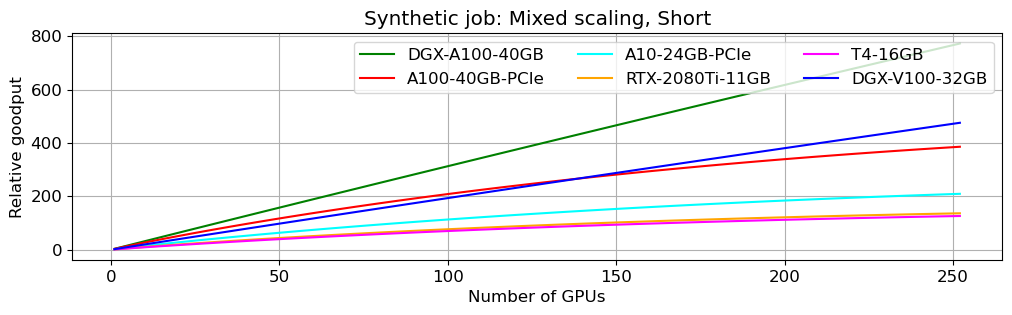

In [227]:
# Mixed-linear: short job
job_configs = {
  "DGX-A100-40GB": {'base_work_per_gpu': 100, 'work_rate_per_gpu': 80, 'work_attentuation_factor': 1e-3, 
                'compute_time_system_overheads_factor': 1e-4, 'base_comm_per_gpu': 0.05, 
                'work_comm_overlap_factor': 0.95},
  "A100-40GB-PCIe": {'base_work_per_gpu': 100, 'work_rate_per_gpu': 75, 'work_attentuation_factor': 1e-3, 
                     'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.2, 
                     'work_comm_overlap_factor': 0.8},
  "A10-24GB-PCIe": {'base_work_per_gpu': 60, 'work_rate_per_gpu': 40, 'work_attentuation_factor': 1e-3, 
                    'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.2, 
                    'work_comm_overlap_factor': 0.8},
  "RTX-2080Ti-11GB": {'base_work_per_gpu': 35, 'work_rate_per_gpu': 30, 'work_attentuation_factor': 2e-3, 
                      'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.25, 
                      'work_comm_overlap_factor': 0.8},
  "T4-16GB": {'base_work_per_gpu': 48, 'work_rate_per_gpu': 25, 'work_attentuation_factor': 2e-3, 
                      'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.25, 
                      'work_comm_overlap_factor': 0.8},
  "DGX-V100-32GB": {'base_work_per_gpu': 70, 'work_rate_per_gpu': 50, 'work_attentuation_factor': 1e-3, 
                    'compute_time_system_overheads_factor': 1e-4, 'base_comm_per_gpu': 0.10, 
                    'work_comm_overlap_factor': 0.95}
}
goodputs = plot_curves(job_configs, gpu_types_to_colors, max_ngpus=256)
plt.title("Synthetic job: Mixed scaling, Short")
job_profile = {"max_progress": 400000, "goodputs": goodputs, "params": job_configs}
with open("../jobs/profiles/synthetic_mixed_short.pkl", "wb") as f:
  pickle.dump(job_profile, f)

GPU type: DGX-A100-40GB, max scaling: 877.2x @ 1020 GPUs

GPU type: A100-40GB-PCIe, max scaling: 158.5x @ 524 GPUs

GPU type: A10-24GB-PCIe, max scaling: 161.0x @ 524 GPUs

GPU type: RTX-2080Ti-11GB, max scaling: 133.2x @ 476 GPUs

GPU type: T4-16GB, max scaling: 149.3x @ 484 GPUs

GPU type: DGX-V100-32GB, max scaling: 854.3x @ 1020 GPUs

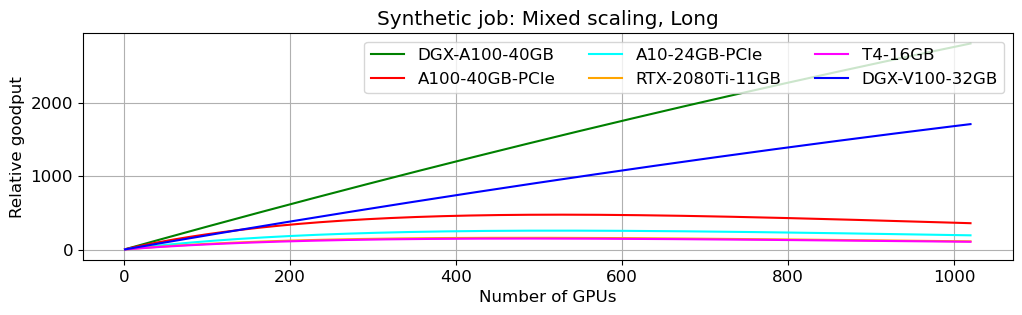

In [228]:
# Mixed-linear: long job
job_configs = {
  "DGX-A100-40GB": {'base_work_per_gpu': 100, 'work_rate_per_gpu': 80, 'work_attentuation_factor': 1e-3, 
                'compute_time_system_overheads_factor': 1e-4, 'base_comm_per_gpu': 0.05, 
                'work_comm_overlap_factor': 0.95},
  "A100-40GB-PCIe": {'base_work_per_gpu': 100, 'work_rate_per_gpu': 75, 'work_attentuation_factor': 1e-3, 
                     'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.2, 
                     'work_comm_overlap_factor': 0.8},
  "A10-24GB-PCIe": {'base_work_per_gpu': 60, 'work_rate_per_gpu': 40, 'work_attentuation_factor': 1e-3, 
                    'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.2, 
                    'work_comm_overlap_factor': 0.8},
  "RTX-2080Ti-11GB": {'base_work_per_gpu': 35, 'work_rate_per_gpu': 30, 'work_attentuation_factor': 2e-3, 
                      'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.25, 
                      'work_comm_overlap_factor': 0.8},
  "T4-16GB": {'base_work_per_gpu': 48, 'work_rate_per_gpu': 25, 'work_attentuation_factor': 2e-3, 
                      'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.25, 
                      'work_comm_overlap_factor': 0.8},
  "DGX-V100-32GB": {'base_work_per_gpu': 80, 'work_rate_per_gpu': 50, 'work_attentuation_factor': 1e-3, 
                    'compute_time_system_overheads_factor': 1e-4, 'base_comm_per_gpu': 0.10, 
                    'work_comm_overlap_factor': 0.95}
}
goodputs = plot_curves(job_configs, gpu_types_to_colors, max_ngpus=1024)
plt.title("Synthetic job: Mixed scaling, Long")
job_profile = {"max_progress": 15000000, "goodputs": goodputs, "params": job_configs}
with open("../jobs/profiles/synthetic_mixed_long.pkl", "wb") as f:
  pickle.dump(job_profile, f)

### Sub-linear scaling on all machines
* Short job: ~10,000 GPU-secs, ~512MB model size
* Long job: ~100,000 GPU-secs, ~2GB model size

GPU type: DGX-A100-40GB, max scaling: 65.5x @ 252 GPUs

GPU type: A100-40GB-PCIe, max scaling: 27.0x @ 252 GPUs

GPU type: A10-24GB-PCIe, max scaling: 23.2x @ 252 GPUs

GPU type: RTX-2080Ti-11GB, max scaling: 17.0x @ 252 GPUs

GPU type: T4-16GB, max scaling: 27.8x @ 252 GPUs

GPU type: DGX-V100-32GB, max scaling: 47.6x @ 252 GPUs

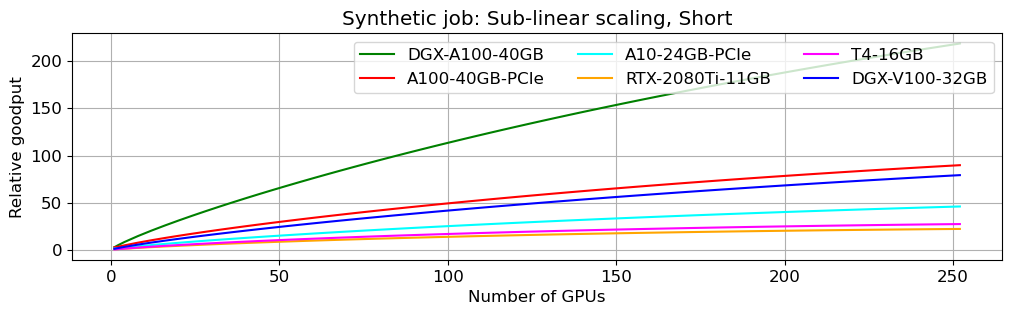

In [229]:
# Sublinear: short job
job_configs = {
  "DGX-A100-40GB": {'base_work_per_gpu': 50, 'work_rate_per_gpu': 500, 'work_attentuation_factor': 1e-3, 
                'compute_time_system_overheads_factor': 1e-3, 'base_comm_per_gpu': 0.05, 
                'work_comm_overlap_factor': 0.5},
  "A100-40GB-PCIe": {'base_work_per_gpu': 50, 'work_rate_per_gpu': 500, 'work_attentuation_factor': 1e-3, 
                     'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.15, 
                     'work_comm_overlap_factor': 0.5},
  "A10-24GB-PCIe": {'base_work_per_gpu': 25, 'work_rate_per_gpu': 300, 'work_attentuation_factor': 1e-3, 
                    'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.15, 
                    'work_comm_overlap_factor': 0.5},
  "RTX-2080Ti-11GB": {'base_work_per_gpu': 15, 'work_rate_per_gpu': 200, 'work_attentuation_factor': 2e-3, 
                      'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.15, 
                      'work_comm_overlap_factor': 0.5},
  "T4-16GB": {'base_work_per_gpu': 20, 'work_rate_per_gpu': 150, 'work_attentuation_factor': 2e-3, 
                      'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.15, 
                      'work_comm_overlap_factor': 0.5},
  "DGX-V100-32GB": {'base_work_per_gpu': 40, 'work_rate_per_gpu': 250, 'work_attentuation_factor': 1e-3, 
                    'compute_time_system_overheads_factor': 1e-3, 'base_comm_per_gpu': 0.125, 
                    'work_comm_overlap_factor': 0.5}
}
goodputs = plot_curves(job_configs, gpu_types_to_colors, max_ngpus=256)
plt.title("Synthetic job: Sub-linear scaling, Short")
job_profile = {"max_progress": 5000000, "goodputs": goodputs, "params": job_configs}
with open("../jobs/profiles/synthetic_sublinear_short.pkl", "wb") as f:
  pickle.dump(job_profile, f)

GPU type: DGX-A100-40GB, max scaling: 74.3x @ 884 GPUs

GPU type: A100-40GB-PCIe, max scaling: 25.2x @ 756 GPUs

GPU type: A10-24GB-PCIe, max scaling: 21.6x @ 768 GPUs

GPU type: RTX-2080Ti-11GB, max scaling: 11.7x @ 424 GPUs

GPU type: T4-16GB, max scaling: 19.8x @ 424 GPUs

GPU type: DGX-V100-32GB, max scaling: 65.4x @ 880 GPUs

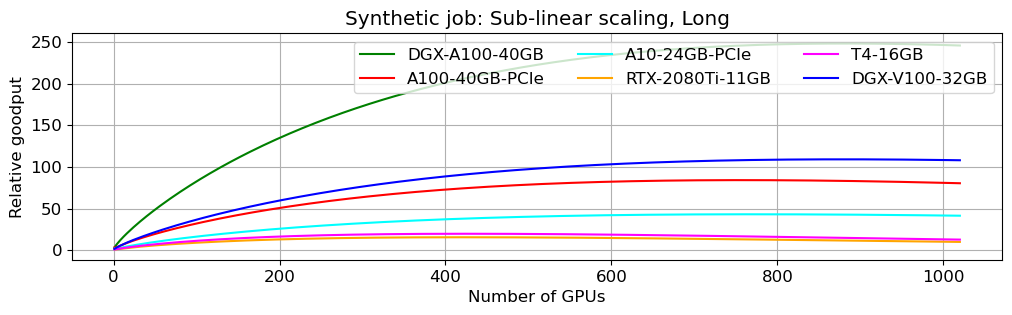

In [230]:
# Sublinear: long job
job_configs = {
  "DGX-A100-40GB": {'base_work_per_gpu': 50, 'work_rate_per_gpu': 500, 'work_attentuation_factor': 1e-3, 
                'compute_time_system_overheads_factor': 1e-3, 'base_comm_per_gpu': 0.08, 
                'work_comm_overlap_factor': 0.5},
  "A100-40GB-PCIe": {'base_work_per_gpu': 50, 'work_rate_per_gpu': 500, 'work_attentuation_factor': 1e-3, 
                     'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.25, 
                     'work_comm_overlap_factor': 0.5},
  "A10-24GB-PCIe": {'base_work_per_gpu': 25, 'work_rate_per_gpu': 300, 'work_attentuation_factor': 1e-3, 
                    'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.25, 
                    'work_comm_overlap_factor': 0.5},
  "RTX-2080Ti-11GB": {'base_work_per_gpu': 15, 'work_rate_per_gpu': 200, 'work_attentuation_factor': 2e-3, 
                      'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.25, 
                      'work_comm_overlap_factor': 0.5},
  "T4-16GB": {'base_work_per_gpu': 20, 'work_rate_per_gpu': 150, 'work_attentuation_factor': 2e-3, 
                      'compute_time_system_overheads_factor': 2e-3, 'base_comm_per_gpu': 0.25, 
                      'work_comm_overlap_factor': 0.5},
  "DGX-V100-32GB": {'base_work_per_gpu': 40, 'work_rate_per_gpu': 250, 'work_attentuation_factor': 1e-3, 
                    'compute_time_system_overheads_factor': 1e-3, 'base_comm_per_gpu': 0.15, 
                    'work_comm_overlap_factor': 0.5}
}
goodputs = plot_curves(job_configs, gpu_types_to_colors, max_ngpus=1024)
plt.title("Synthetic job: Sub-linear scaling, Long")
job_profile = {"max_progress": 60000000, "goodputs": goodputs, "params": job_configs}
with open("../jobs/profiles/synthetic_sublinear_long.pkl", "wb") as f:
  pickle.dump(job_profile, f)